# Fraud Classification

**Imports:**

In [96]:
import ast
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from typing import Dict, Callable

As we saw previously, the data is unbalanced in terms of the target variable, and there are several values missing.


In this case there are two categorical variables with missing values: "establecimiento" and "ciudad". We could imputate data with, for example, the most comon city and establishment, or we could fill them ramdomly so that each type of city/establishment is uniformly distributed. However, the fact tha the city or the establishment are missing from the data, could be useful to predict whether or not the transaction is fraudulent. For this case, we are going to replace all missing values with the "UNK" keyword, so that the classifier takes into account when any of the two variables is missign

In [97]:
fraud_data_path = "../data/ds_challenge_2021.csv"
fraud_df = pd.read_csv(fraud_data_path)
fraud_df = fraud_df.fillna("UNK")

We should also handle the date and device features since they are objects. 

In [98]:
print(fraud_df.fecha.head())
print(fraud_df.dispositivo.head())

0    2020-01-21
1    2020-01-15
2    2020-01-17
3    2020-01-05
4    2020-01-30
Name: fecha, dtype: object
0    {'model': 2020, 'device_score': 3, 'os': 'ANDR...
1    {'model': 2020, 'device_score': 1, 'os': 'ANDR...
2        {'model': 2020, 'device_score': 1, 'os': '.'}
3      {'model': 2020, 'device_score': 3, 'os': 'WEB'}
4       {'model': 2020, 'device_score': 3, 'os': '%%'}
Name: dispositivo, dtype: object


We are going to split the date column into the columns: "year", "month" and "day" . We are also going to parse the device column separating it into 2 columns. The "model" component of the device is always the literal 2020, so it doesn't contribute with useful information and we are not going to take it into account. We eliminate the device column and replace it with two new columns: "device_score" and "device_os".

We also want to drop the ID_USER column at it's not useful to predict fraud.

In [99]:
# Parsing dates
fraud_df[["year", "month", "day"]] = fraud_df.fecha.str.split("-", expand=True).astype("int")
fraud_df = fraud_df.drop("fecha", axis=1)

# Parse device
fraud_df["device_score"] = fraud_df.dispositivo.apply(lambda s: ast.literal_eval(s)["device_score"])
fraud_df["device_os"] = fraud_df.dispositivo.apply(lambda s: ast.literal_eval(s)["os"])
fraud_df = fraud_df.drop("dispositivo", axis=1)

# Drop user ID
fraud_df = fraud_df.drop("ID_USER", axis=1)

fraud_df.head()

genero       monto  hora establecimiento       ciudad  tipo_tc  linea_tc  \
0      F  608.345634    20           Super       Merida   Física     71000   
1      F   88.719243     7             UNK       Merida  Virtual     71000   
2      F  790.037653    11             UNK  Guadalajara  Virtual     94000   
3      F  767.005387    11           MPago  Guadalajara   Física     94000   
4      F  254.171053    10             UNK  Guadalajara   Física     94000   

   interes_tc  status_txn  is_prime       dcto   cashback  fraude  year  \
0          51    Aceptada     False  60.834563   5.475111   False  2020   
1          51    Aceptada     False   0.000000   1.774385   False  2020   
2          56  En proceso     False   0.000000  15.800753   False  2020   
3          56    Aceptada     False   0.000000   7.670054   False  2020   
4          56    Aceptada     False   0.000000   2.541711   False  2020   

   month  day  device_score device_os  
0      1   21             3   ANDROID  
1      1   15             1   ANDROID  
2      1   17             1         .  
3      1    5             3       WEB  
4      1   30             3        %%

To use the Random Forest we need to encode all categorial variables into numbers:

In [100]:
fraud_obj_cols = fraud_df.select_dtypes(include=["object"]).columns

def encode_column (X: pd.DataFrame) -> Callable[[str], Dict[str, int]]:
    def encode (col: str) -> Dict[str, int]:
        unq = X[col].unique()
        return dict(zip(unq, range(0, unq.shape[0])))
    return encode

encoder = encode_column(fraud_df)
encoded = dict(zip(
    fraud_obj_cols,
    map(encoder, fraud_obj_cols)
))

fraud_df = fraud_df.replace(encoded)
fraud_df.head()

genero       monto  hora  establecimiento  ciudad  tipo_tc  linea_tc  \
0       0  608.345634    20                0       0        0     71000   
1       0   88.719243     7                1       0        1     71000   
2       0  790.037653    11                1       1        1     94000   
3       0  767.005387    11                2       1        0     94000   
4       0  254.171053    10                1       1        0     94000   

   interes_tc  status_txn  is_prime       dcto   cashback  fraude  year  \
0          51           0     False  60.834563   5.475111   False  2020   
1          51           0     False   0.000000   1.774385   False  2020   
2          56           1     False   0.000000  15.800753   False  2020   
3          56           0     False   0.000000   7.670054   False  2020   
4          56           0     False   0.000000   2.541711   False  2020   

   month  day  device_score  device_os  
0      1   21             3          0  
1      1   15             1          0  
2      1   17             1          1  
3      1    5             3          2  
4      1   30             3          3

First we are going to see the results with a Random Forest clasifier with the data as-is, to generate a baseline for the evaluation of the model. We test with Random Forest since we are not sure if the features can be splitted linearly with respect to the target.

We split the dataset into 75% test and 25% test

In [101]:
X = fraud_df.drop("fraude", axis=1)
y = fraud_df.fraude

# split data
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.25, random_state= 97)

randForest = RandomForestClassifier(n_estimators=100)
randForest.fit(X_train, y_train)

y_pred = randForest.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

0.9676749703440095


Although the prediction shows high accuracy, since there are many more examples of non-fraudulent transactions, this meassurement is not representative of how well the model can predict fraude. 



In [104]:
conf_mat = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, y_pred),
    index=["actual_false", "actual_true"],
    columns=["pred_false", "pred_true"]
)

print(f"n = {X_test.shape[0]}")
print(f"# fraud = {y_test[y_test].shape[0]}")
print(f"Presicion = {metrics.precision_score(y_test, y_pred)}")
print(f"Recall = {metrics.recall_score(y_test, y_pred)}")

conf_mat

n = 6744
# fraud = 218
Presicion = 0.0
Recall = 0.0


/home/sebastian/.pyenv/versions/rpp-ds-challenge/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


pred_false  pred_true
actual_false        6526          0
actual_true          218          0

As we can see, the couldn't predict a single one as a fraud case. We are going to try to create a model after oversampling the fraud data using SMOTE and see the differences.

In [105]:
X_train_over, y_train_over = SMOTE().fit_resample(X_train, y_train)
y_train_over.value_counts()

False    19639
True     19639
Name: fraude, dtype: int64

We know build the model using the new dataset.

In [106]:
randForest = RandomForestClassifier(n_estimators=100)
randForest.fit(X_train_over, y_train_over)

y_pred = randForest.predict(X_test)

print(f"n = {X_test.shape[0]}")
print(f"# fraud = {y_test[y_test].shape[0]}")
print(f"Accuracy = {metrics.accuracy_score(y_test, y_pred)}")
print(f"Presicion = {metrics.precision_score(y_test, y_pred)}")
print(f"Recall = {metrics.recall_score(y_test, y_pred)}")

conf_mat = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, y_pred),
    index=["actual_false", "actual_true"],
    columns=["pred_false", "pred_true"]
)
conf_mat

n = 6744
# fraud = 218
Accuracy = 0.9218564650059312
Presicion = 0.024615384615384615
Recall = 0.03669724770642202


pred_false  pred_true
actual_false        6209        317
actual_true          210          8

We see that we predicted much more cases as fraud, but only 8 of them are true positives. We should now select the optimal hyperparameters for the random forest model, to see if we can get better results. We will use cross validation and tune the following parameters (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):

- n_estimators (number of trees)
- criterion (gini or entropy)
- max_depth (max depth of each tree)
- min_samples_split (min number of samples required to split a node)
- bootstrap (True or False, whether or not to bootstrap the samples when building the trees)

In [83]:
grid = {
    "n_estimators": np.arange(100, 900, 100, dtype=np.int_),
    "criterion": ["gini", "entropy"],
    #"max_depth": np.arange(10, 110, 20, dtype=np.int_),
    #"min_samples_split": np.arange(2, 10, 3, dtype=np.int_),
    "bootstrap": [True, False]
}

randForest = RandomForestClassifier()
randForest_cv = RandomizedSearchCV(
    estimator=randForest,
    param_distributions=grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=97
)
randForest_cv.fit(X_train_over, y_train_over)

print(randForest_cv.best_params_)

/home/sebastian/.pyenv/versions/rpp-ds-challenge/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END ...bootstrap=True, criterion=gini, n_estimators=100; total time=   5.1s
[CV] END ...bootstrap=True, criterion=gini, n_estimators=100; total time=   5.2s
[CV] END ...bootstrap=True, criterion=gini, n_estimators=100; total time=   5.1s
[CV] END ...bootstrap=True, criterion=gini, n_estimators=200; total time=  10.1s
[CV] END ...bootstrap=True, criterion=gini, n_estimators=200; total time=  10.4s
[CV] END ...bootstrap=True, criterion=gini, n_estimators=200; total time=  10.4s
[CV] END ...bootstrap=True, criterion=gini, n_estimators=300; total time=  15.1s
[CV] END ...bootstrap=True, criterion=gini, n_estimators=300; total time=  15.5s
[CV] END ...bootstrap=True, criterion=gini, n_estimators=300; total time=  15.6s
[CV] END ...bootstrap=True, criterion=gini, n_estimators=400; total time=  20.0s
[CV] END ...bootstrap=True, criterion=gini, n_estimators=400; total time=  20.7s
[CV] END ...bootstrap=True, criterion=gini, n_es

Now we check the performance of this model

In [84]:
y_pred = randForest_cv.predict(X_test)

print(f"n = {X_test.shape[0]}")
print(f"# fraud = {y_test[y_test].shape[0]}")
print(f"Accuracy = {metrics.accuracy_score(y_test, y_pred)}")
print(f"Presicion = {metrics.precision_score(y_test, y_pred)}")
print(f"Recall = {metrics.recall_score(y_test, y_pred)}")

conf_mat = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, y_pred),
    index=["actual_false", "actual_true"],
    columns=["pred_false", "pred_true"]
)
conf_mat

n = 6744
# fraud = 218
Accuracy = 0.9405397390272835
Presicion = 0.0106951871657754
Recall = 0.009174311926605505


pred_false  pred_true
actual_false        6341        185
actual_true          216          2

This gave us worst performance, we should modify the ranges, folds and iterations. **NOTE:** For higher ranges, the cross validation couldn't finish before the deadline of this challenge.

## Useful features

RandomForest can give us a score per feature, determining how useful it was for predicting the target

<AxesSubplot:>

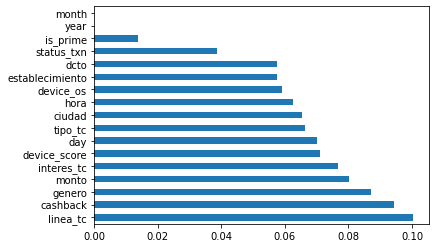

In [107]:
randForest = RandomForestClassifier(n_estimators=100)
randForest.fit(X_train_over, y_train_over)

important_feats = pd.Series(
    randForest.feature_importances_,
    index=X_train_over.columns
).sort_values(ascending=False)

important_feats.plot.barh()

In this case the most important features where "linea_tc", "cashback" and "genero". Notice however that the best scores don't surpass 10%.
We can also see that month and year should be removed from the training since they don't add useful information.

In [ ]:
import pickle

# Save model
out_path = "../data/randomForestModel"
with open(out_path, "wb") as out_file:
    pickle.dump(randForest, out_file)

## Conclusions and Further Work

- We saw that with an unbalanced dataset, the model couldn't predict any of the fraud examples. Adding artificial fraud examples to the training dataset help the model to predict more fraudulent transactions.
- We could add a new feature with the clustering done in the *clien_categorization* notebook, to see if the prediction improves.
- We could try other techniques to overcome the issue of inbalanc; for example, using a *Cost Sensitive Learning* technique.
- The current model has a lot false negative and false positives. We could try to build a model to focus on reducing the false negatives. It is better to predict some transactions as fraud, even if they are not, and then check manually the transactions, than to miss-predict something that is fraud.